## Capstone Final Assessment

In [1]:
!wget -O loan_train.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv

--2020-11-16 21:13:12--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

loan_train.csv      100%[===================>]  22.56K  --.-KB/s    in 0.07s   

2020-11-16 21:13:12 (304 KB/s) - ‘loan_train.csv’ saved [23101/23101]



In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics, preprocessing, linear_model, neighbors, tree, svm, model_selection
from scipy.stats import zscore

In [2]:
table = pd.read_csv('loan_train.csv')
table.head(5)

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


### Clean dataset and Encode data

In [3]:
table = table.drop(labels=['Unnamed: 0','Unnamed: 0.1','effective_date','due_date'],axis=1)

#Paid Encoding
PAID = preprocessing.LabelEncoder()
PAID.fit(table['loan_status'])
table['paid'] = PAID.transform(table['loan_status'])

#Gender Encoding
Gender = preprocessing.LabelEncoder()
table['gender'] = Gender.fit(table['Gender']).transform(table['Gender'])

#Edu Encoding
edu = preprocessing.LabelEncoder()
table['edu'] = edu.fit(table['education']).transform(table['education'])

#Principal Encoding
princ = preprocessing.LabelEncoder()
table['principal'] = princ.fit(table['Principal']).transform(table['Principal'])

#Turn terms and age into z-score evaluations
table['z_age'] = zscore(table['age'].to_numpy())
table['z_terms'] = zscore(table['terms'].to_numpy())

table = table.drop(labels=['loan_status','age','terms','Gender','education','Principal'],axis=1)
table.head()

,paid,gender,edu,principal,z_age,z_terms
0,1,1,1,4,2.331526,0.920718
1,1,0,0,4,0.341701,0.920718
2,1,1,3,4,-0.653211,-0.959111
3,1,0,3,4,-0.487392,0.920718
4,1,1,3,4,-0.321573,0.920718


In [4]:
def colorSel(x) :
    color = []
    for i in x:
        if i == 1 :
            color.append('blue')
        else :
            color.append('red')
    return color
cols = colorSel(table['paid'])

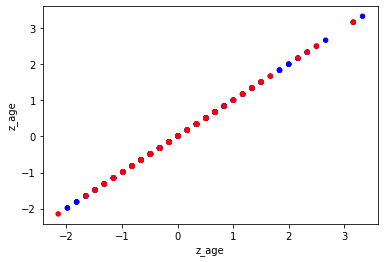

In [5]:
table.plot(x='z_age',y='z_age',kind='scatter',color=cols)

In [21]:
xTrain, xTest, yTrain, yTest = model_selection.train_test_split(table[['edu','z_age','z_terms']].to_numpy(),
                                                                table['paid'].to_numpy(),
                                                                test_size = 0.3)

## ML Methods
### K Nearest Neighbors

In [40]:
jKNN = []; f1KNN = []; logKNN=[]
for i in range(10) :
    KNN = neighbors.KNeighborsClassifier(n_neighbors=i+1)
    KNN.fit(xTrain,yTrain)
    yHat = KNN.predict(xTest)
    jKNN.append(metrics.jaccard_score(yHat,yTest))
    f1KNN.append(metrics.f1_score(yHat,yTest))
    logKNN.append(metrics.log_loss(yHat,yTest))

#### Evaluate KNN Performance

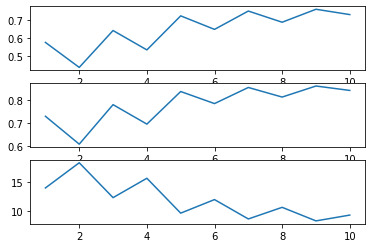

In [41]:
fig, ax= plt.subplots(3)
ax[0].plot(list(range(1,11)),jKNN)
ax[1].plot(list(range(1,11)),f1KNN)
ax[2].plot(list(range(1,11)),logKNN)

In [42]:
perfPeakIdx = np.where(jKNN == np.amax(jKNN))[0].item()
print('Peak performance is reached with '+str(perfPeakIdx+1)+' Nearest Neighbors:' +
      '\n\tJaccard = ' + str(jKNN[perfPeakIdx]) +
      '\n\tF1 Score = ' +str(f1KNN[perfPeakIdx]) + 
      '\n\tLogLoss = ' + str(logKNN[perfPeakIdx]))

Peak performance is reached with 9 Nearest Neighbors:
	Jaccard = 0.7572815533980582
	F1 Score = 0.8618784530386739
	LogLoss = 8.302613544856325
